In [1]:
from scipy import stats

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt

In [2]:
# compare area of rim fire to area of TLG watershed

tlg = gp.read_file("../shape/sierra_catchments.shp")
tlg = tlg[tlg['stid'] =='TLG']
rim_fire = gp.read_file("../shape/mtbs_rim_fire_bounds.shp")

In [3]:
rfa_km2 = rim_fire['Acres'].values[0] * 0.00404686
tlga_km2 = tlg['area_km2'].values[0]

no_burn = 28967 * 0.00404686
low_burn = 60243 * 0.00404686
med_burn = 69138 * 0.00404686
high_burn = 98049 * 0.00404686

print("Rim fire area = {}".format(str(rfa_km2)))
print("TLG watershed area = {}".format(str(tlga_km2)))
print("proportion of burned watershed = {}".format(rfa_km2/tlga_km2))

print("Pct no burn = {}".format(no_burn/tlga_km2))
print("Pct low burn = {}".format(low_burn/tlga_km2))
print("Pct med burn = {}".format(med_burn/tlga_km2))
print("Pct high burn = {}".format(high_burn/tlga_km2))
print("NO + LOW + MED + HIGH = {}".format(str(no_burn + low_burn + med_burn + high_burn)))

Rim fire area = 1040.38295624
TLG watershed area = 4722.405299999999
proportion of burned watershed = 0.2203078495274432
Pct no burn = 0.024823238619522982
Pct low burn = 0.05162517223585194
Pct med burn = 0.05924773265013913
Pct high burn = 0.08402298213158453
NO + LOW + MED + HIGH = 1037.60276342


<AxesSubplot:>

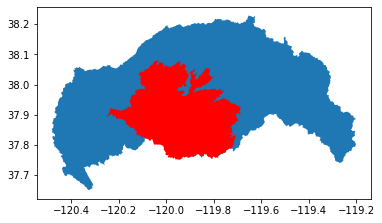

In [4]:
ax = tlg.plot(label = 'Tuoluomne watershed', legend = True)
rim_fire.plot(ax = ax, color = 'red', label = 'Rim Fire (2013)')

In [5]:
bf = pd.read_csv("../data/baseflow_sep/baseflow_mm.csv")
bf.index = pd.to_datetime(bf['date'])
bf.drop("date", axis = 1, inplace = True)
bf[bf<0] = np.nan
bf = bf.interpolate(how='linear')

sr = pd.read_csv("../data/baseflow_sep/surface_runoff_mm.csv")
sr.index = pd.to_datetime(sr['date'])
sr.drop("date", axis = 1, inplace = True)
sr[sr<0] = np.nan
sr = sr.interpolate(how='linear')

In [6]:
fire_date = datetime.datetime(2013, 8, 27)

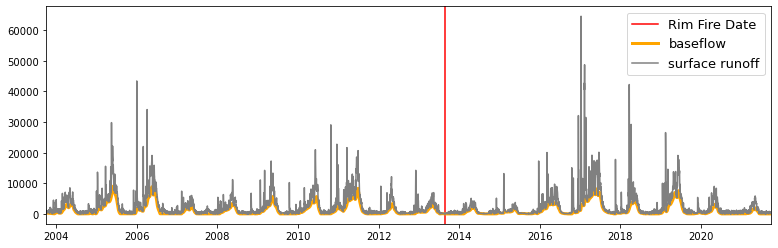

In [7]:
plt.figure(figsize = (13,4))
plt.axvline(fire_date, color = 'red', label = 'Rim Fire Date')
plt.plot(bf.index, bf['TLG'], color = 'orange', linewidth=3, label = 'baseflow')
plt.plot(sr.index, bf['TLG']+sr['TLG'], color = 'gray', label = 'surface runoff')
plt.xlim(datetime.datetime(2003, 10,1), datetime.datetime(2021, 10, 1))
plt.legend(fontsize = 13)

Text(0, 0.5, 'percentage of total streamflow')

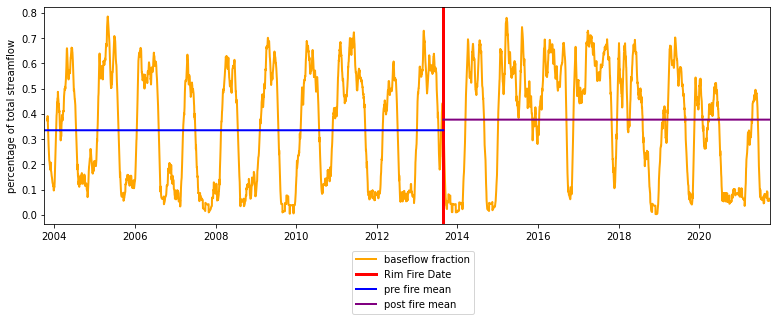

In [8]:
bf_frac = bf['TLG'] / (bf['TLG'] + sr['TLG'])
sr_frac = sr['TLG'] / (bf['TLG'] + sr['TLG'])

pre_fire_frac = pd.DataFrame(bf_frac[bf_frac.index<fire_date])
post_fire_frac = pd.DataFrame(bf_frac[bf_frac.index>fire_date])

pre_fire_frac['mean'] = np.repeat(pre_fire_frac['TLG'].mean(), len(pre_fire_frac.index))
post_fire_frac['mean'] = np.repeat(post_fire_frac['TLG'].mean(), len(post_fire_frac.index))

fig = plt.figure(figsize = (13,4))
ax = plt.subplot(111)
ax.plot(bf.index, bf_frac.rolling(30).mean().values, color = 'orange', linewidth=2, label = 'baseflow fraction')
# ax.plot(sr.index, sr_frac.rolling(30).mean().values, color = 'gray', linewidth = 2, label = 'surface runoff fraction')
ax.axvline(fire_date, color = 'red', linewidth = 3, label = 'Rim Fire Date')
plt.xlim(datetime.datetime(2003, 10,1), datetime.datetime(2021, 10, 1))

ax.plot(pre_fire_frac.index,pre_fire_frac['mean'], color = 'blue', linewidth = 2, label = 'pre fire mean')
ax.plot(post_fire_frac.index,post_fire_frac['mean'], color = 'purple', linewidth = 2, label = 'post fire mean')

# ax.legend(loc = 'upper left')
ax.legend(bbox_to_anchor=(0.6, -.1))
ax.set_ylabel("percentage of total streamflow")


In [9]:
# Reset the indices for linear regressio
# post_fire_frac.reset_index(inplace = True)
post_fire_frac['idx'] = post_fire_frac.reset_index().index

# pre_fire_frac.reset_index(inplace = True)
pre_fire_frac['idx'] = pre_fire_frac.reset_index().index

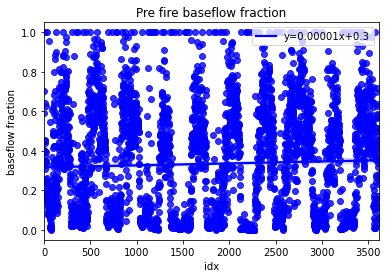

In [10]:
# Pre Fire 

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(pre_fire_frac['idx'],pre_fire_frac['TLG'])

# use line_kws to set line label for legend
ax = sns.regplot(x="idx", y="TLG", data=pre_fire_frac, color='blue',
 line_kws={'label':"y={0:.5f}x+{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.title("Pre fire baseflow fraction")
plt.ylabel('baseflow fraction')
plt.show()


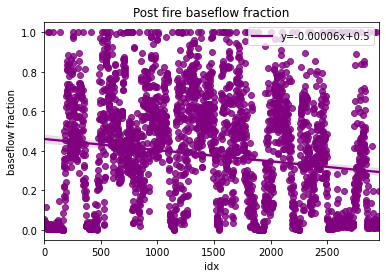

In [11]:
# Post Fire 

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(post_fire_frac['idx'],post_fire_frac['TLG'])

# use line_kws to set line label for legend
ax = sns.regplot(x="idx", y="TLG", data=post_fire_frac, color='purple',
 line_kws={'label':"y={0:.5f}x+{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()


plt.title("Post fire baseflow fraction")
plt.ylabel('baseflow fraction')
plt.show()


In [12]:
slope

-5.6485869440659386e-05

In [13]:

et = np.load("../data/et/TLG_et.npy")
et[et==9.999] = np.nan
et = et/1000.
# remove nans
smlt = np.load("../data/smlt/TLG_smlt.npy")
prcp = np.load("../data/prcp/TLG_prcp.npy")

In [14]:
prcp_mean = np.nanmean(prcp, axis = 2) * 365
smlt_mean = np.nanmean(smlt, axis = 2) * 365 * 24 # since it is hourly snapshot
et_mean = np.nanmean(et, axis = 2) * 365

<ipython-input-14-637ff430775c>:1: RuntimeWarning: Mean of empty slice
  prcp_mean = np.nanmean(prcp, axis = 2) * 365
<ipython-input-14-637ff430775c>:2: RuntimeWarning: Mean of empty slice
  smlt_mean = np.nanmean(smlt, axis = 2) * 365 * 24 # since it is hourly snapshot
<ipython-input-14-637ff430775c>:3: RuntimeWarning: Mean of empty slice
  et_mean = np.nanmean(et, axis = 2) * 365


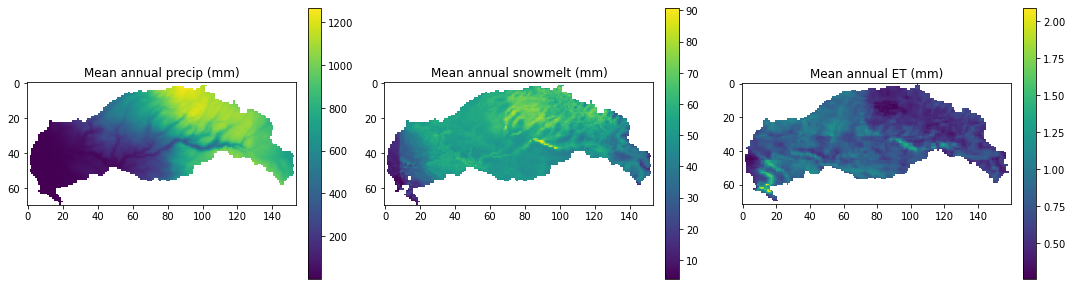

In [15]:
plt.figure(figsize = (15,15))

plt.subplot(131)
plt.imshow(prcp_mean); plt.colorbar(fraction=0.046, pad=0.04); plt.title("Mean annual precip (mm)")
plt.subplot(132)
plt.imshow(smlt_mean); plt.colorbar(fraction=0.046, pad=0.04); plt.title("Mean annual snowmelt (mm)")
plt.subplot(133)
plt.imshow(et_mean); plt.colorbar(fraction=0.046, pad=0.04); plt.title("Mean annual ET (mm)")

plt.tight_layout()
plt.show()

In [16]:
prcp_ts = np.nanmean(prcp, axis = 1)
smlt_ts = np.nanmean(smlt, axis = 1) * 24 # since it is hourly snapshot
et_ts = np.nanmean(et, axis = 1) 

<ipython-input-16-795fffe3de76>:1: RuntimeWarning: Mean of empty slice
  prcp_ts = np.nanmean(prcp, axis = 1)
<ipython-input-16-795fffe3de76>:2: RuntimeWarning: Mean of empty slice
  smlt_ts = np.nanmean(smlt, axis = 1) * 24 # since it is hourly snapshot


In [17]:
def return_2d_array(arr):
    outarrs = []
    for i in range(arr.shape[2]):
        ts = arr[:,:,i]
        outarrs.append(np.nansum(ts))
    
    return np.array(outarrs)

In [18]:
prcp_ts = return_2d_array(prcp)
smlt_ts = return_2d_array(smlt)
et_ts = return_2d_array(et)

In [19]:
pdf = pd.DataFrame(prcp_ts)
pdf.index = pd.date_range("2003-10-01",'2021-09-30')

etdf = pd.DataFrame(et_ts)
etdf.index = pd.date_range("2000-01-01",'2020-12-30')

smdf = pd.DataFrame(smlt_ts)
smdf.index = pd.date_range("2003-10-01",'2021-09-30')

Text(0, 0.5, 'mm')

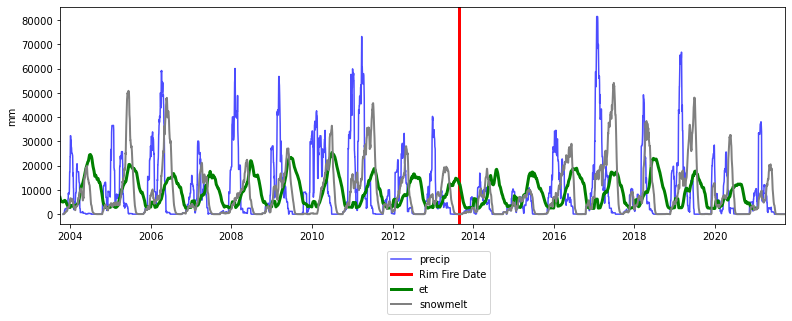

In [20]:

fig = plt.figure(figsize = (13,4))
ax = plt.subplot(111)
ax.plot(pdf.index, pdf.rolling(30).mean().values, color = 'blue',alpha = 0.7, label = 'precip')
ax.axvline(fire_date, color = 'red', linewidth = 3, label = 'Rim Fire Date')
# ax.legend(bbox_to_anchor=(1.05, 1.35))

# ax2 = ax.twinx()
ax.plot(etdf.index, etdf.rolling(30).mean() *720, color = 'green' ,linewidth = 3 , label = 'et')
ax.plot(smdf.index, smdf.rolling(30).mean().interpolate(how = 'linear').values *720 , color = 'gray', linewidth = 2, label = 'snowmelt')
ax.legend(bbox_to_anchor=(1.05, 1.25))
plt.xlim(datetime.datetime(2003, 10,1), datetime.datetime(2021, 10, 1))

ax.legend(bbox_to_anchor=(0.6, -.1))
# ax.legend(bbox_to_anchor=(1.05, 1.2))
ax.set_ylabel("mm")